**Importing libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import time
from PIL import Image
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, optimizers, losses
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

**Preprocessing**

In [6]:
# Define paths
dataset_path = "DatasetStore"

#breed_list = os.listdir(os.path.join(dataset_path, 'Annotation'))
breed_list.sort()
selected_breeds = np.random.choice(breed_list, 10, replace=False)

# Strip the numerical prefixes from the selected breeds
clean_selected_breeds = [breed.split('-')[1] for breed in selected_breeds]
print("Selected Breeds:", clean_selected_breeds)

# Create label index for selected breeds
label2index = {name: index for index, name in enumerate(selected_breeds)}
index2label = {index: name for name, index in label2index.items()}

Selected Breeds: ['Border_terrier', 'American_Staffordshire_terrier', 'Ibizan_hound', 'Tibetan_terrier', 'groenendael', 'Irish_setter', 'Pekinese', 'miniature_schnauzer', 'Doberman', 'dingo']


In [9]:
images = []
annotations = []
for breed in selected_breeds:
    image_files = os.listdir(os.path.join(dataset_path, 'Images', breed))
    image_files.sort()
    images.extend([os.path.join(dataset_path, 'Images', breed, f) for f in image_files])
    annotations.extend([os.path.join(dataset_path, 'Annotation', breed, f.replace(".jpg", "")) for f in image_files])

for idx, ann in enumerate(annotations):
    annotations[idx] = ann.split("/")[2]  # add dog breed name

# Prepare train test validate datasets
Xs = np.asarray(images)
Ys = np.asarray(annotations)

# Filter data for only the selected breeds
selected_indices = [i for i, y in enumerate(Ys) if y in selected_breeds]
Xs = Xs[selected_indices]
Ys = Ys[selected_indices]

print('Xs shape', Xs.shape)
print(Xs[:5])
print('Ys shape', Ys.shape)
print(Ys[:5])


Xs shape (1644,)
['DatasetStore/Images/n02093754-Border_terrier/n02093754_1062.jpg'
 'DatasetStore/Images/n02093754-Border_terrier/n02093754_1100.jpg'
 'DatasetStore/Images/n02093754-Border_terrier/n02093754_1102.jpg'
 'DatasetStore/Images/n02093754-Border_terrier/n02093754_1111.jpg'
 'DatasetStore/Images/n02093754-Border_terrier/n02093754_1148.jpg']
Ys shape (1644,)
['n02093754-Border_terrier' 'n02093754-Border_terrier'
 'n02093754-Border_terrier' 'n02093754-Border_terrier'
 'n02093754-Border_terrier']


In [10]:
# Split into train_validate + test data
train_validate_x, test_x, train_validate_y, test_y = train_test_split(Xs, Ys, test_size=0.1)

print("train_validate_x shape:", train_validate_x.shape)
print('train_validate_x[:5]:', train_validate_x[:5])
print("train_validate_y shape:", train_validate_y.shape)
print('train_validate_y[:5]:', train_validate_y[:5])

print("test_x shape:", test_x.shape)
print('test_x[:5]:', test_x[:5])
print("test_y shape:", test_y.shape)
print('test_y[:5]:', test_y[:5])


train_validate_x shape: (1479,)
train_validate_x[:5]: ['DatasetStore/Images/n02107142-Doberman/n02107142_17450.jpg'
 'DatasetStore/Images/n02115641-dingo/n02115641_13450.jpg'
 'DatasetStore/Images/n02107142-Doberman/n02107142_278.jpg'
 'DatasetStore/Images/n02093428-American_Staffordshire_terrier/n02093428_443.jpg'
 'DatasetStore/Images/n02097474-Tibetan_terrier/n02097474_3976.jpg']
train_validate_y shape: (1479,)
train_validate_y[:5]: ['n02107142-Doberman' 'n02115641-dingo' 'n02107142-Doberman'
 'n02093428-American_Staffordshire_terrier' 'n02097474-Tibetan_terrier']
test_x shape: (165,)
test_x[:5]: ['DatasetStore/Images/n02093428-American_Staffordshire_terrier/n02093428_13615.jpg'
 'DatasetStore/Images/n02115641-dingo/n02115641_1940.jpg'
 'DatasetStore/Images/n02093754-Border_terrier/n02093754_2457.jpg'
 'DatasetStore/Images/n02097047-miniature_schnauzer/n02097047_3534.jpg'
 'DatasetStore/Images/n02107142-Doberman/n02107142_1251.jpg']
test_y shape: (165,)
test_y[:5]: ['n02093428-Ameri

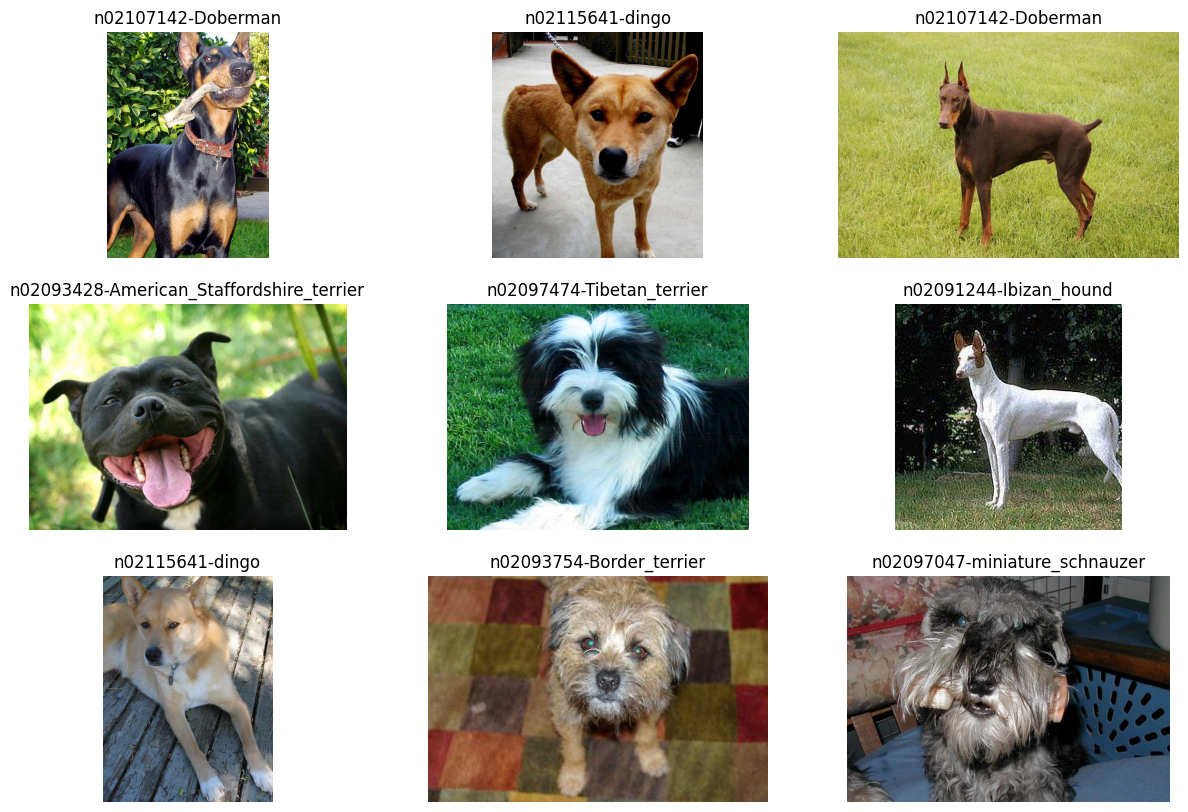

In [11]:
# Visualize some training images
fig = plt.figure(figsize=(15, 10))
for idx in range(9):
    sample_input = cv2.imread(train_validate_x[idx])
    sample_input = cv2.cvtColor(sample_input, cv2.COLOR_BGR2RGB)
    breed = train_validate_y[idx]
    axs = fig.add_subplot(3, 3, idx + 1)
    axs.set_title(breed)
    plt.imshow(sample_input)
    plt.axis('off')
plt.show()



In [12]:
validation_percent = 0.2
image_width = 64
image_height = 64
num_channels = 3
num_classes = len(selected_breeds)

epochs = 30
train_batch_size = 16
validation_batch_size = 16
test_batch_size = 16

In [13]:
# Split data into train / validation
train_x, validate_x, train_y, validate_y = train_test_split(train_validate_x, train_validate_y, test_size=validation_percent)

# Converts to binary class matrix (One-hot-encoded)
train_processed_y = np.asarray([label2index[label] for label in train_y])
validate_processed_y = np.asarray([label2index[label] for label in validate_y])
test_processed_y = np.asarray([label2index[label] for label in test_y])
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='float32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='float32')
test_processed_y = to_categorical(test_processed_y, num_classes=num_classes, dtype='float32')

train_data_count = train_x.shape[0]
steps_per_epoch = int(train_data_count / train_batch_size)
validation_data_count = validate_x.shape[0]
validation_steps = int(validation_data_count / validation_batch_size)

AUTOTUNE = tf.data.experimental.AUTOTUNE


In [14]:
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=num_channels)
    image = tf.image.resize(image, [image_height, image_width])
    return image, label

# Normalize pixels
def normalize(image, label):
    image = image / 255.0
    return image, label

def build_data_generators(train_data_process_list=[load_image, normalize], validate_data_process_list=[load_image, normalize], test_data_process_list=[load_image, normalize]):

    # Create TF Dataset
    train_data = tf.data.Dataset.from_tensor_slices((train_x.tolist(), train_processed_y.tolist()))
    validation_data = tf.data.Dataset.from_tensor_slices((validate_x.tolist(), validate_processed_y.tolist()))
    test_data = tf.data.Dataset.from_tensor_slices((test_x.tolist(), test_processed_y.tolist()))

    # Train data
    train_data = train_data.shuffle(train_data_count)
    for process in train_data_process_list:
        train_data = train_data.map(process, num_parallel_calls=AUTOTUNE)
    train_data = train_data.repeat(epochs).batch(train_batch_size)

    # Validation data
    validation_data = validation_data.shuffle(validation_data_count)
    for process in validate_data_process_list:
        validation_data = validation_data.map(process, num_parallel_calls=AUTOTUNE)
    validation_data = validation_data.repeat(epochs).batch(validation_batch_size)

    # Test data
    for process in test_data_process_list:
        test_data = test_data.map(process, num_parallel_calls=AUTOTUNE)
    test_data = test_data.repeat(1).batch(test_batch_size)

    return train_data, validation_data, test_data


**Model Building**

In [18]:
train_data, validation_data, test_data = build_data_generators()
print("train_data", train_data)
print("validation_data", validation_data)
print("test_data", test_data)

mobilenet_v2 = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(image_height, image_width, 3))

def view_layers(model):
  layers = model.layers
  layers_list = []

  for idx, layer in enumerate(layers):
      layers_list.append({
        'layer': type(layer).__name__,
          'trainable': layer.trainable
        })

  df = pd.DataFrame(layers_list)
  return df

train_data <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
validation_data <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
test_data <_BatchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
9406464/9406464 [==============================] - 0s 0us/step


In [19]:
layers_df = view_layers(mobilenet_v2)
print(layers_df[10:])

learning_rate = 0.01
for layer in mobilenet_v2.layers[:-4]:
    layer.trainable = False

model_input = mobilenet_v2.input

hidden = mobilenet_v2.layers[-1]
print("Pool Layer", hidden)

# Flatten
hidden = layers.Flatten()(hidden.output)

# Hidden Layer, Classification Block
hidden = layers.Dense(units=512, activation='relu')(hidden)
hidden = layers.Dense(units=512, activation='relu')(hidden)

# Output Layer
output = layers.Dense(units=num_classes, activation='softmax')(hidden)

# Build model
model = Model(model_input, output, name='MobileNetV2')

# Optimizer
optimizer = optimizers.SGD(learning_rate=learning_rate)

# Loss
loss = losses.categorical_crossentropy

# Compile
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])


                  layer  trainable
10   BatchNormalization       True
11                 ReLU       True
12        ZeroPadding2D       True
13      DepthwiseConv2D       True
14   BatchNormalization       True
..                  ...        ...
149              Conv2D       True
150  BatchNormalization       True
151              Conv2D       True
152  BatchNormalization       True
153                ReLU       True

[144 rows x 2 columns]
Pool Layer <keras.src.layers.activation.relu.ReLU object at 0x7e989f06e560>


In [20]:
layers_df = view_layers(model)
print(layers_df.head(25))

earlystopping = EarlyStopping(monitor='val_accuracy', patience=10)

# Model Checkpoint
checkpoint_filepath = './Checkpoints/checkpoint_MobileNetV2'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True
)


                 layer  trainable
0           InputLayer      False
1               Conv2D      False
2   BatchNormalization      False
3                 ReLU      False
4      DepthwiseConv2D      False
5   BatchNormalization      False
6                 ReLU      False
7               Conv2D      False
8   BatchNormalization      False
9               Conv2D      False
10  BatchNormalization      False
11                ReLU      False
12       ZeroPadding2D      False
13     DepthwiseConv2D      False
14  BatchNormalization      False
15                ReLU      False
16              Conv2D      False
17  BatchNormalization      False
18              Conv2D      False
19  BatchNormalization      False
20                ReLU      False
21     DepthwiseConv2D      False
22  BatchNormalization      False
23                ReLU      False
24              Conv2D      False


**Model Training**

In [21]:
start_time = time.time()
training_results = model.fit(
    train_data,
    validation_data=validation_data,
    callbacks=[earlystopping, model_checkpoint_callback],
    epochs=epochs,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)
execution_time = (time.time() - start_time) / 60.0
print("Training execution time (mins)", execution_time)

Epoch 1/30
73/73 [==============================] - ETA: 0s - loss: 2.0002 - accuracy: 0.3065
Epoch 1: val_accuracy improved from -inf to 0.36806, saving model to ./Checkpoints/checkpoint_MobileNetV2
73/73 [==============================] - 17s 153ms/step - loss: 2.0002 - accuracy: 0.3065 - val_loss: 1.7141 - val_accuracy: 0.3681
Epoch 2/30
73/73 [==============================] - ETA: 0s - loss: 1.1446 - accuracy: 0.6541
Epoch 2: val_accuracy improved from 0.36806 to 0.39236, saving model to ./Checkpoints/checkpoint_MobileNetV2
73/73 [==============================] - 9s 125ms/step - loss: 1.1446 - accuracy: 0.6541 - val_loss: 1.8470 - val_accuracy: 0.3924
Epoch 3/30
73/73 [==============================] - ETA: 0s - loss: 0.7387 - accuracy: 0.8022
Epoch 3: val_accuracy improved from 0.39236 to 0.46528, saving model to ./Checkpoints/checkpoint_MobileNetV2
73/73 [==============================] - 10s 141ms/step - loss: 0.7387 - accuracy: 0.8022 - val_loss: 1.7308 - val_accuracy: 0.4653

**Evaluating test results**

In [22]:
evaluation_results = model.evaluate(test_data, verbose=1)

# Print the evaluation results
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

11/11 [==============================] - 1s 59ms/step - loss: 2.0789 - accuracy: 0.5030
Test Loss: 2.0789411067962646
Test Accuracy: 0.5030303001403809


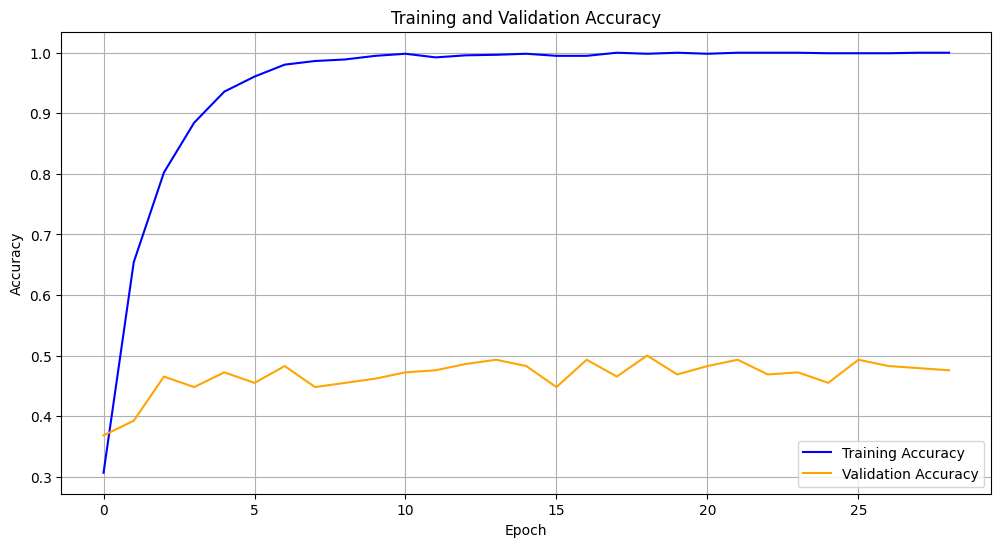

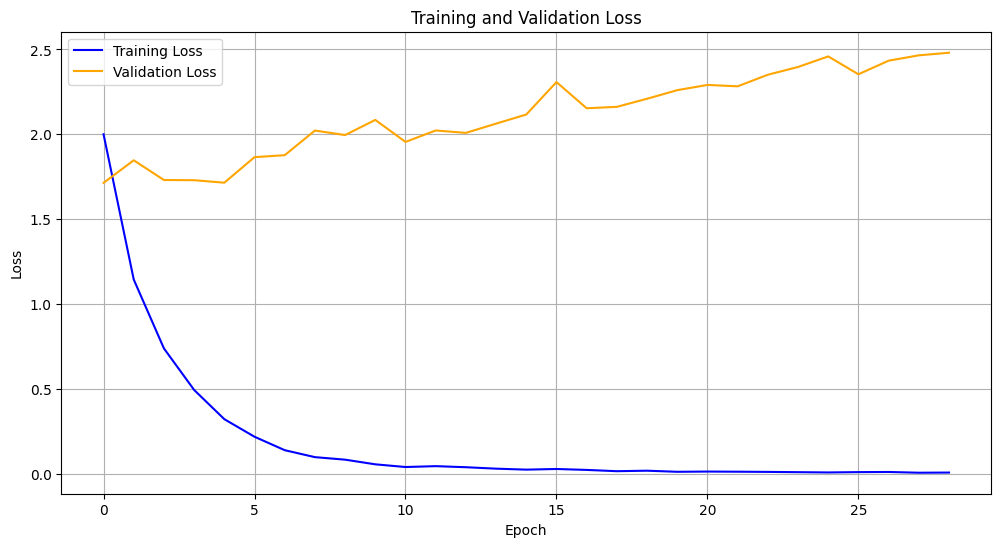

In [23]:
train_accuracy = training_results.history['accuracy']
val_accuracy = training_results.history['val_accuracy']
train_loss = training_results.history['loss']
val_loss = training_results.history['val_loss']

# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()